In [1]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma as gf
from scipy.special import hyp1f1 as Mf

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# Analytic moment constraints

In an attempt to address the issues with poor model enforcement by moments (overdispersed poisson data remaining feasible) try adding analytic expressions for the moments of model as constraints.

Previously only constrained expression for moments in terms of probabilities, which then constrain parameters via CME equations. But, if we have expressions for the model moments in terms of the model parameters e.g. poisson model, then these can be used as constraints to directly link moments to parameters.

However, remains unclear if this can be used for more complicated models e.g. interacting birth-death, where analytic expressions for the model moments may not be available.

# Code

In [17]:
def optimize_moment(M, k, a, b, delta, deltasq, gamma=0.0, silent=True, printing=True, time_limit=300, var=False, analytic=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    delta: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    analytic: toggle analytic moment constraints
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = {}# json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # analytic moment constraints
            if analytic:
                model.addConstr(expr_EX_OG == k_tx, name="analytic_EX")
                if var:
                    model.addConstr(expr_EX2_OG == k_tx + k_tx**2, name="analytic_EX_2")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [18]:
def fm_numeric(m ,a, b, k):
    '''Numeric computation of f_m = E[Beta|m] for Beta~Beta(a,b) capture.'''

    # terms
    t1 = gf(b + m + a) / gf(m + a)
    t2 = gf(m + a + 1) / gf(b + m + a + 1)
    t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

    # numerical computation of fm
    fm_num = t1 * t2 * t3

    return fm_num

In [162]:
def optimize_moment_downsampled(M, k, a, b, delta, deltasq, gamma=0.0, deltam=0.0, silent=True, printing=True, time_limit=300, var=False, analytic=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    deltasq: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    deltam: width of fm intervals about truth
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    analytic: toggle analytic moment constraints
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = {} #json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            fm = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="fm", lb=0, ub=1)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OB)
            expr_EX_OB = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OB = gp.quicksum(p * np.arange(M + 1)**2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # analytic moment constraints
            if analytic:

                # moment variables (OG)
                expr_EX_OG = model.addVar(vtype=GRB.CONTINUOUS, name="EX_OG", lb=0)
                if var:
                    expr_EX2_OG = model.addVar(vtype=GRB.CONTINUOUS, name="EX2_OG", lb=0)

                # relate to moments (OB)
                model.addConstr(expr_EX_OB == expr_EX_OG * Ebeta, name="EX_OB_to_OG")
                if var:
                    model.addConstr(expr_EX2_OB == expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2), name="EX2_OB_to_OG")

                # analytic expressions for moments (OG)
                model.addConstr(expr_EX_OG == k_tx, name="analytic_EX")
                if var:
                    model.addConstr(expr_EX2_OG == k_tx + k_tx**2, name="analytic_EX_2")

            # fm intervals
            for m in range(M + 1):
                fm_num = fm_numeric(m, a, b, k)
                model.addConstr(fm[m] <= fm_num + (deltam / 2))
                model.addConstr(fm[m] >= fm_num - (deltam / 2))

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - fm[0] * k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == fm[x - 1] * k_tx * p[x - 1] + (x + 1) * p[x + 1] - (fm[x] * k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

# Results

## Test

Believe numerical issues are causing the infeasibility of OG moment + analytic constraints at $\delta = 0$: any non-zero value is feasible and gives bounds very close to $2$.

In [163]:
print("Standard:\n")
print("1st Moment:")
solution_s1 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_s2 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

print("\nDownsampled:\n")
print("1st Moment:")
solution_d1 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_d2 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

Standard:

1st Moment:
k_tx in (2.0, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL

Downsampled:

1st Moment:
k_tx in (1.9998567730024175, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (1.9999849986008067, 2.000258939999257), status OPTIMAL, OPTIMAL


In [166]:
print("Standard:\n")
print("1st Moment:")
solution_s1 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False, analytic=True)
print("1st and 2nd Moments:")
solution_s2 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True, analytic=True)

print("\nDownsampled:\n")
print("1st Moment:")
solution_d1 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False, analytic=True)
print("1st and 2nd Moments:")
solution_d2 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True, analytic=True)

Standard:

1st Moment:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (None, None), status INFEASIBLE, INFEASIBLE

Downsampled:

1st Moment:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL


## Effect of $\delta$

Analytic constraints tighten bounds across a range of $\delta$, slightly improving lower bound for smaller widths and significantly improving upper bound, especially for wider widths.

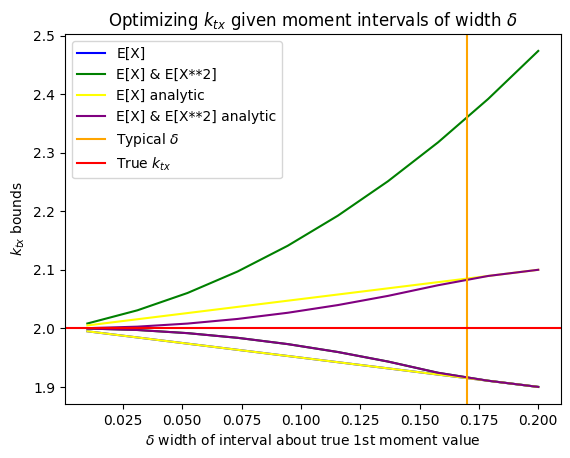

In [27]:
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
b = 0
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
lbs_moment_any = []
ubs_moment_any = []
lbs_moment_any_var = []
ubs_moment_any_var = []
for delta in deltas:
    solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=False)
    solution_moment_var = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
    solution_moment_any = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=False, analytic=True)
    solution_moment_any_var = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, analytic=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
    lbs_moment_any.append(solution_moment_any['min'])
    ubs_moment_any.append(solution_moment_any['max'])
    lbs_moment_any_var.append(solution_moment_any_var['min'])
    ubs_moment_any_var.append(solution_moment_any_var['max'])
plt.title(r"Optimizing $k_{tx}$ given moment intervals of width $\delta$")
plt.xlabel(r"$\delta$ width of interval about true 1st moment value")
plt.ylabel(r"$k_{tx}$ bounds")
plt.plot(deltas, lbs_moment, color="blue", label="E[X]")
#plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, lbs_moment_var, color="green", label="E[X] & E[X**2]")
plt.plot(deltas, ubs_moment_var, color="green")
plt.plot(deltas, lbs_moment_any, color="yellow", label="E[X] analytic")
plt.plot(deltas, ubs_moment_any, color="yellow")
plt.plot(deltas, lbs_moment_any_var, color="purple", label="E[X] & E[X**2] analytic")
plt.plot(deltas, ubs_moment_any_var, color="purple")
plt.axvline(0.17, color="orange", label=r"Typical $\delta$")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

## Effect of $\beta$

Analytic constraints significantly tighten upper bounds on $k_{tx}$ across a range of mean capture values, espically for lower values (e.g. 10%). Little difference between OG and OB (downsampled) performance.

In [ ]:
# settings
#deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
#bs = [0, 1, 5, 10, 20]
#ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# range of mean capture efficiency
mean_capture_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# map to beta parameters
a = 1
bs = [(1 / m) - 1 for m in mean_capture_range]

# map to delta widths
deltas = [0.175 - 0.13*(m - 1)**2 for m in mean_capture_range]

# store results
lbs_moment = []
ubs_moment = []
lbs_moment_any = []
ubs_moment_any = []
lbs_moment_down = []
ubs_moment_down = []
lbs_moment_down_any = []
ubs_moment_down_any = []

# for each capture
for i, m in enumerate(mean_capture_range):

    # get values
    b = bs[i]
    delta = deltas[i]

    # moment
    solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])

    # moment + analytic
    solution_moment_any = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, analytic=True)
    lbs_moment_any.append(solution_moment_any['min'])
    ubs_moment_any.append(solution_moment_any['max'])

    # downsampled moment
    solution_moment_down = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
    lbs_moment_down.append(solution_moment_down['min'])
    ubs_moment_down.append(solution_moment_down['max'])

    # downsampled moment + analytic
    solution_moment_down_any = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True, analytic=True)
    lbs_moment_down_any.append(solution_moment_down_any['min'])
    ubs_moment_down_any.append(solution_moment_down_any['max'])

'\n# plot\nfig, axs = plt.subplots(figsize=(10, 10))\nplt.title(r"Lower bounds on $k_{tx}$ for capture $\x08eta \\sim \text{Beta}(1, b)$")\nplt.xlabel(r"Interval width $\\delta$")\nplt.ylabel(r"$k_{tx}$")\n\naxs.plot(ds, lbs_moment, label="Moment", color="blue")\naxs.plot(ds, ubs_moment, color="blue")\n\naxs.plot(ds, lbs_moment_any, label="Moment + Analytic", color="orange")\naxs.plot(ds, ubs_moment_any, color="orange")\n\naxs.plot(ds, lbs_moment_down, label="Downsampled Moment", color="green")\naxs.plot(ds, ubs_moment_down, color="green")\n\naxs.plot(ds, lbs_moment_down_any, label="Downsampled Moment + Analytic", color="purple")\naxs.plot(ds, ubs_moment_down_any, color="purple")\n    \n#axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f\'C{i}\')\n#axs.axvline(ds[i], color=f\'C{i}\')\naxs.axhline(k, color="red", label=r"True $k_{tx}$")\nplt.legend()\n'

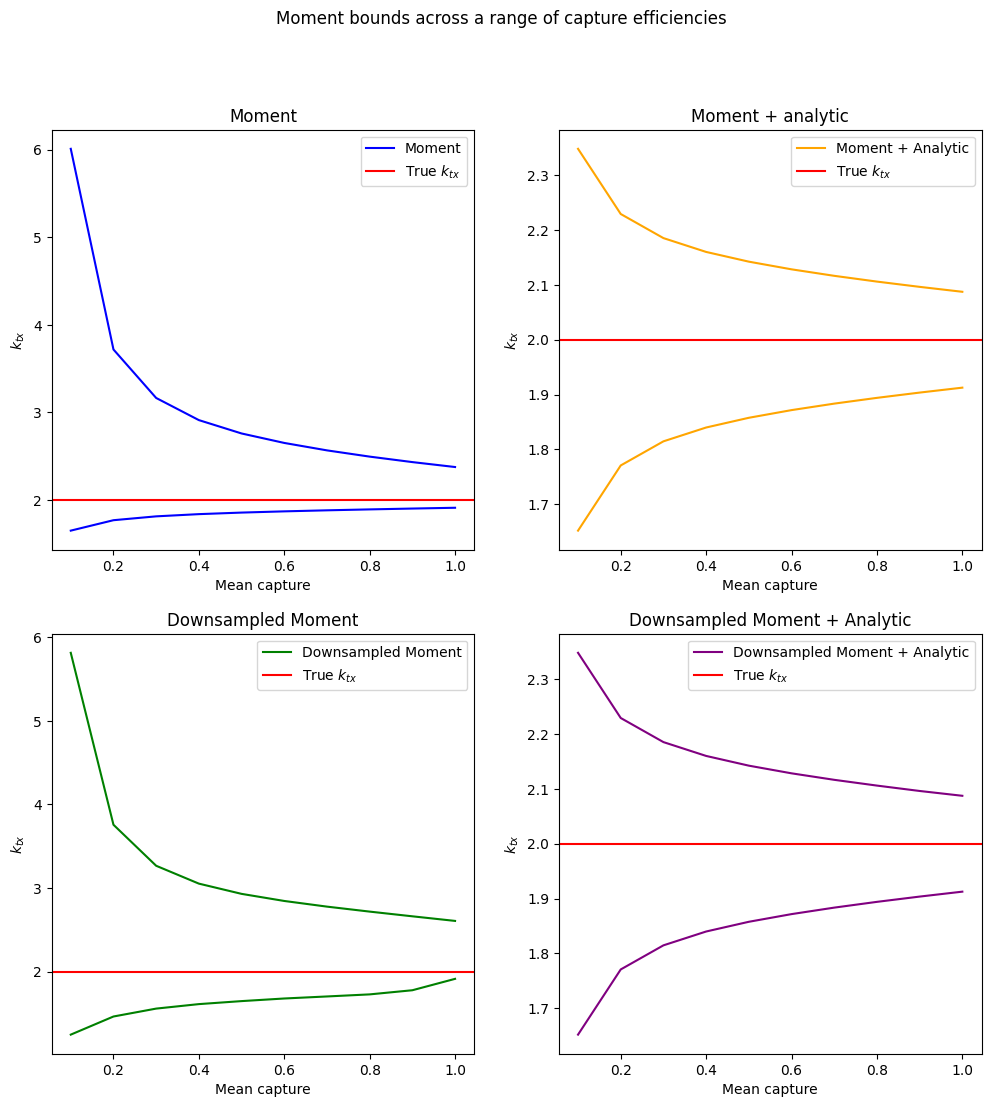

In [ ]:
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

plt.suptitle("Moment bounds across a range of capture efficiencies")

axs[0, 0].plot(mean_capture_range, lbs_moment, label="Moment", color="blue")
axs[0, 0].plot(mean_capture_range, ubs_moment, color="blue")
axs[0, 0].axhline(k, color="red", label=r"True $k_{tx}$")
axs[0, 0].set_xlabel("Mean capture")
axs[0, 0].set_ylabel(r"$k_{tx}$")
axs[0, 0].set_title("Moment")
axs[0, 0].legend()

axs[0, 1].plot(mean_capture_range, lbs_moment_any, label="Moment + Analytic", color="orange")
axs[0, 1].plot(mean_capture_range, ubs_moment_any, color="orange")
axs[0, 1].axhline(k, color="red", label=r"True $k_{tx}$")
axs[0, 1].set_xlabel("Mean capture")
axs[0, 1].set_ylabel(r"$k_{tx}$")
axs[0, 1].set_title("Moment + analytic")
axs[0, 1].legend()

axs[1, 0].plot(mean_capture_range, lbs_moment_down, label="Downsampled Moment", color="green")
axs[1, 0].plot(mean_capture_range, ubs_moment_down, color="green")
axs[1, 0].axhline(k, color="red", label=r"True $k_{tx}$")
axs[1, 0].set_xlabel("Mean capture")
axs[1, 0].set_ylabel(r"$k_{tx}$")
axs[1, 0].set_title("Downsampled Moment")
axs[1, 0].legend()

axs[1, 1].plot(mean_capture_range, lbs_moment_down_any, label="Downsampled Moment + Analytic", color="purple")
axs[1, 1].plot(mean_capture_range, ubs_moment_down_any, color="purple")
axs[1, 1].axhline(k, color="red", label=r"True $k_{tx}$")
axs[1, 1].set_xlabel("Mean capture")
axs[1, 1].set_ylabel(r"$k_{tx}$")
axs[1, 1].set_title("Downsampled Moment + Analytic")
axs[1, 1].legend()

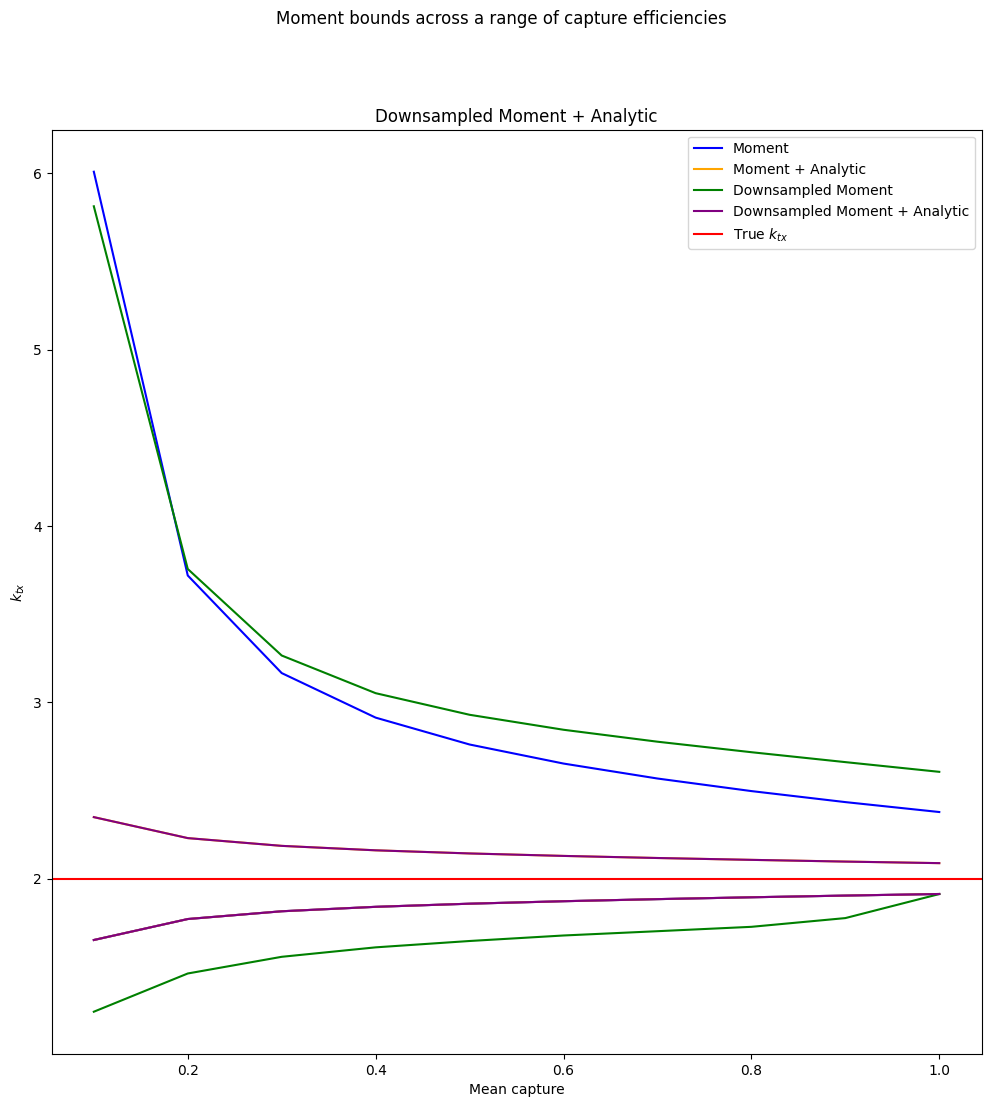

In [170]:
# plot
fig, axs = plt.subplots(figsize=(12, 12))

plt.suptitle("Moment bounds across a range of capture efficiencies")

axs.plot(mean_capture_range, lbs_moment, label="Moment", color="blue")
axs.plot(mean_capture_range, ubs_moment, color="blue")

axs.plot(mean_capture_range, lbs_moment_any, label="Moment + Analytic", color="orange")
axs.plot(mean_capture_range, ubs_moment_any, color="orange")

axs.plot(mean_capture_range, lbs_moment_down, label="Downsampled Moment", color="green")
axs.plot(mean_capture_range, ubs_moment_down, color="green")

axs.plot(mean_capture_range, lbs_moment_down_any, label="Downsampled Moment + Analytic", color="purple")
axs.plot(mean_capture_range, ubs_moment_down_any, color="purple")
axs.axhline(k, color="red", label=r"True $k_{tx}$")
axs.set_xlabel("Mean capture")
axs.set_ylabel(r"$k_{tx}$")
axs.set_title("Downsampled Moment + Analytic")
axs.legend()

## Non poisson input

When a bias of $\gamma = \pm 1$ was added to the second moment to give anon-poisson input (so should be infeasible), only the negative value results in infeasibility.

However, with added analytic constraints, both result in infeasiblity.

Optimizing over a range of $\gamma$ values we see that all analytic constraints mean all $\gamma \ne 0$ values lead to infeasibility, which is the ideal result.

This happens at 50% capture for both OG and OB (downsampled) optimizations, so hopefully moments now enforce the model correctly.

In [172]:
# settings
n = 0.5
M = 100
k = 2
a = 1
b = (1 / m) - 1
delta = 0.175 - 0.13 * (m - 1)**2
deltasq = 30 * delta**2

# gamma bias
gamma = 1

# Moment
print("\nMoment\n")
solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=True, silent=True, time_limit=60, var=True)
solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=-gamma, printing=True, silent=True, time_limit=60, var=True)

# Downsampled Moment
print("\nDownsampled Moment\n")
solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=True, silent=True, time_limit=60, var=True)
solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=-gamma, printing=True, silent=True, time_limit=60, var=True)

# Moment + Analytic
print("\nMoment + Analytic\n")
solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=True, silent=True, time_limit=60, var=True, analytic=True)
solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=-gamma, printing=True, silent=True, time_limit=60, var=True, analytic=True)

# Downsampled Moment + ANalytic
print("\nDownsampled Moment + Analytic\n")
solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=True, silent=True, time_limit=60, var=True, analytic=True)
solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=-gamma, printing=True, silent=True, time_limit=60, var=True, analytic=True)



Moment

k_tx in (2.133233532934132, 2.900326797385895), status OPTIMAL, OPTIMAL
k_tx in (None, None), status INFEASIBLE, INFEASIBLE

Downsampled Moment

k_tx in (2.1235322776847116, 3.178485901776856), status OPTIMAL, OPTIMAL
k_tx in (None, None), status INFEASIBLE, INFEASIBLE

Moment + Analytic

k_tx in (None, None), status INFEASIBLE, INFEASIBLE
k_tx in (None, None), status INFEASIBLE, INFEASIBLE

Downsampled Moment + Analytic

k_tx in (None, None), status INFEASIBLE, INFEASIBLE
k_tx in (None, None), status INFEASIBLE, INFEASIBLE


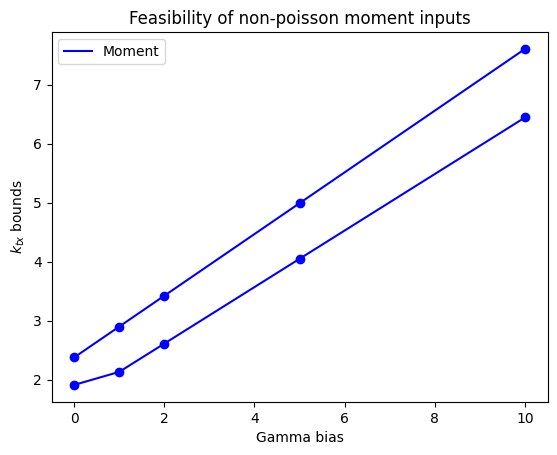

In [173]:
# settings
n = 0.5
M = 100
k = 2
a = 1
b = (1 / m) - 1
delta = 0.175 - 0.13 * (m - 1)**2
deltasq = 30 * delta**2
analytic = False

# gamma bias
gammas_pos = [1, 2, 5, 10]
gammas_neg = [-gamma for gamma in gammas_pos]
gammas_neg.reverse()

# gamma = 0
solution_zero = optimize_moment(M, k, a, b, delta, deltasq, gamma=0, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)

# gamma > 0
lbs_moment_pos = []
ubs_moment_pos = []
stop_flag = False
for gamma in gammas_pos:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_pos.append(solution_moment['min'])
        ubs_moment_pos.append(solution_moment['max'])
    else:
        lbs_moment_pos.append(np.nan)
        ubs_moment_pos.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag_pos = True

# gamma < 0
lbs_moment_neg = []
ubs_moment_neg = []
stop_flag = False
for gamma in gammas_neg:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_neg.append(solution_moment['min'])
        ubs_moment_neg.append(solution_moment['max'])
    else:
        lbs_moment_neg.append(np.nan)
        ubs_moment_neg.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag = True

gammas = gammas_neg + [0] + gammas_pos
lbs = lbs_moment_neg + [solution_zero['min']] + lbs_moment_pos
ubs = ubs_moment_neg + [solution_zero['max']] + ubs_moment_pos

plt.plot(gammas, lbs, color="blue", label="Moment")
plt.scatter(gammas, lbs, color="blue")
plt.plot(gammas, ubs, color="blue")
plt.scatter(gammas, ubs, color="blue")
plt.xlabel("Gamma bias")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Feasibility of non-poisson moment inputs")
plt.legend()

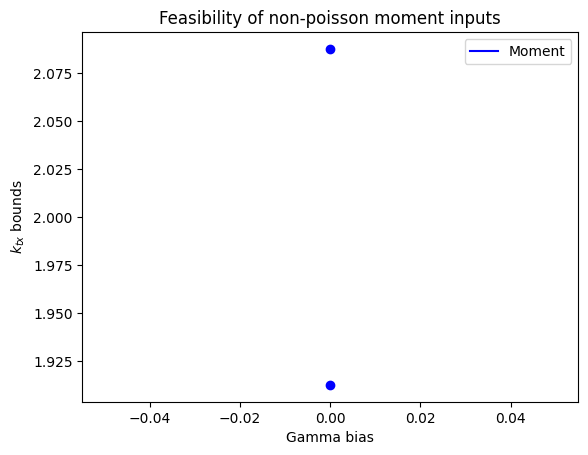

In [174]:
# settings
n = 0.5
M = 100
k = 2
a = 1
b = (1 / m) - 1
delta = 0.175 - 0.13 * (m - 1)**2
deltasq = 30 * delta**2
analytic = True

# gamma bias
gammas_pos = [1, 2, 5, 10]
gammas_neg = [-gamma for gamma in gammas_pos]
gammas_neg.reverse()

# gamma = 0
solution_zero = optimize_moment(M, k, a, b, delta, deltasq, gamma=0, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)

# gamma > 0
lbs_moment_pos = []
ubs_moment_pos = []
stop_flag = False
for gamma in gammas_pos:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_pos.append(solution_moment['min'])
        ubs_moment_pos.append(solution_moment['max'])
    else:
        lbs_moment_pos.append(np.nan)
        ubs_moment_pos.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag_pos = True

# gamma < 0
lbs_moment_neg = []
ubs_moment_neg = []
stop_flag = False
for gamma in gammas_neg:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment(M, k, a, b, delta, deltasq, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_neg.append(solution_moment['min'])
        ubs_moment_neg.append(solution_moment['max'])
    else:
        lbs_moment_neg.append(np.nan)
        ubs_moment_neg.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag = True

gammas = gammas_neg + [0] + gammas_pos
lbs = lbs_moment_neg + [solution_zero['min']] + lbs_moment_pos
ubs = ubs_moment_neg + [solution_zero['max']] + ubs_moment_pos

plt.plot(gammas, lbs, color="blue", label="Moment")
plt.scatter(gammas, lbs, color="blue")
plt.plot(gammas, ubs, color="blue")
plt.scatter(gammas, ubs, color="blue")
plt.xlabel("Gamma bias")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Feasibility of non-poisson moment inputs")
plt.legend()

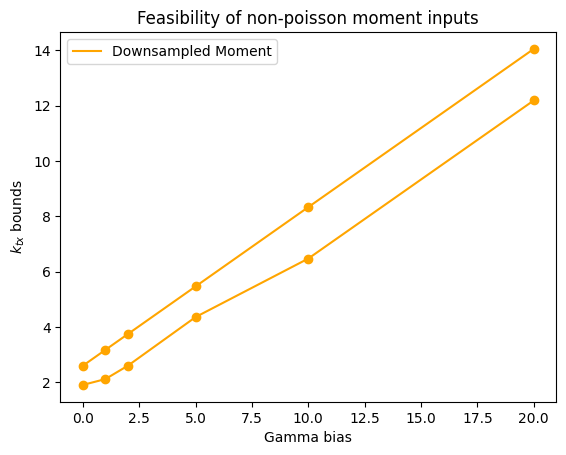

In [175]:
# settings
n = 0.5
M = 100
k = 2
a = 1
b = (1 / m) - 1
delta = 0.175 - 0.13 * (m - 1)**2
deltasq = 30 * delta**2
analytic = False

# gamma bias
gammas_pos = [1, 2, 5, 10, 20]
gammas_neg = [-gamma for gamma in gammas_pos]
gammas_neg.reverse()

# gamma = 0
solution_zero = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=0, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)

# gamma > 0
lbs_moment_pos = []
ubs_moment_pos = []
stop_flag = False
for gamma in gammas_pos:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_pos.append(solution_moment['min'])
        ubs_moment_pos.append(solution_moment['max'])
    else:
        lbs_moment_pos.append(np.nan)
        ubs_moment_pos.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag_pos = True

# gamma < 0
lbs_moment_neg = []
ubs_moment_neg = []
stop_flag = False
for gamma in gammas_neg:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_neg.append(solution_moment['min'])
        ubs_moment_neg.append(solution_moment['max'])
    else:
        lbs_moment_neg.append(np.nan)
        ubs_moment_neg.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag = True

gammas = gammas_neg + [0] + gammas_pos
lbs = lbs_moment_neg + [solution_zero['min']] + lbs_moment_pos
ubs = ubs_moment_neg + [solution_zero['max']] + ubs_moment_pos

plt.plot(gammas, lbs, color="orange", label="Downsampled Moment")
plt.scatter(gammas, lbs, color="orange")
plt.plot(gammas, ubs, color="orange")
plt.scatter(gammas, ubs, color="orange")
plt.xlabel("Gamma bias")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Feasibility of non-poisson moment inputs")
plt.legend()

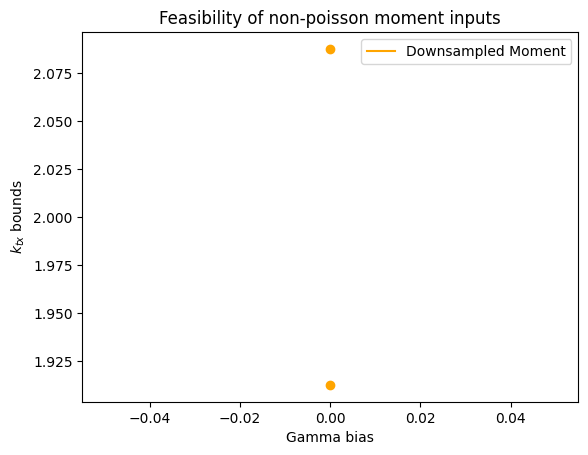

In [176]:
# settings
n = 0.5
M = 100
k = 2
a = 1
b = (1 / m) - 1
delta = 0.175 - 0.13 * (m - 1)**2
deltasq = 30 * delta**2
analytic = True

# gamma bias
gammas_pos = [1, 2, 5, 10, 20]
gammas_neg = [-gamma for gamma in gammas_pos]
gammas_neg.reverse()

# gamma = 0
solution_zero = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=0, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)

# gamma > 0
lbs_moment_pos = []
ubs_moment_pos = []
stop_flag = False
for gamma in gammas_pos:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_pos.append(solution_moment['min'])
        ubs_moment_pos.append(solution_moment['max'])
    else:
        lbs_moment_pos.append(np.nan)
        ubs_moment_pos.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag_pos = True

# gamma < 0
lbs_moment_neg = []
ubs_moment_neg = []
stop_flag = False
for gamma in gammas_neg:

    # optimize
    if not stop_flag:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltasq, deltam=delta, gamma=gamma, printing=False, silent=True, time_limit=60, var=True, analytic=analytic)
        lbs_moment_neg.append(solution_moment['min'])
        ubs_moment_neg.append(solution_moment['max'])
    else:
        lbs_moment_neg.append(np.nan)
        ubs_moment_neg.append(np.nan)

    # stop once infeasible
    if solution_moment['min_status'] == "INFEASIBLE":
        stop_flag = True

gammas = gammas_neg + [0] + gammas_pos
lbs = lbs_moment_neg + [solution_zero['min']] + lbs_moment_pos
ubs = ubs_moment_neg + [solution_zero['max']] + ubs_moment_pos

plt.plot(gammas, lbs, color="orange", label="Downsampled Moment")
plt.scatter(gammas, lbs, color="orange")
plt.plot(gammas, ubs, color="orange")
plt.scatter(gammas, ubs, color="orange")
plt.xlabel("Gamma bias")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Feasibility of non-poisson moment inputs")
plt.legend()

# Realistic $\delta$ values: typical bootstrap interval widths

Determine typical interval widths for moment bootstrap estimates in order to choose good $\delta$ values. Taking $\delta$ as width of $\mathbb{E}[X]$ interval, and $\delta_2$ as width of $\mathbb{E}[X^2]$.

For $k_{tx} = 2$ and a mean capture efficiency (beta distributed) of $m$:

$$ \delta \approx 0.175 - 0.13 (m - 1)^2 $$

and:

$$ \delta_2 = 30 \delta^2 $$

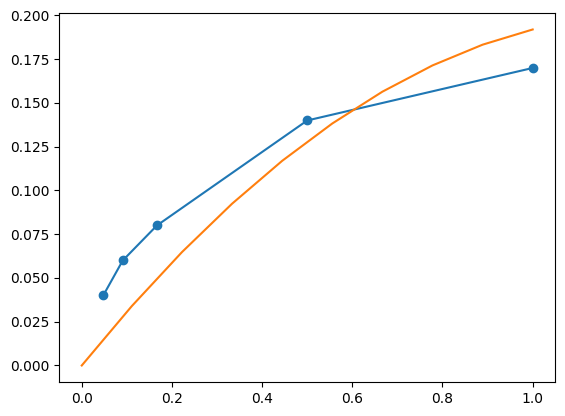

In [73]:
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]
ps = [1 / (1 + b) for b in bs]

plt.plot(ps, ds)
plt.scatter(ps, ds)
x = np.linspace(0, 1, 10)
plt.plot(x, 0.2* (1 - (0.8*x - 1)**2))

In [74]:
from interaction_inference import simulation

In [75]:
rng = np.random.default_rng()

In [77]:
# capture range to test
capture_means = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bs = [(1 / m) - 1 for m in capture_means]

# settings
k = 2

# store deltas
delta_dict = {}

# simulate
dataset = simulation.simulate_dataset_range_BD("test", [0 for j in range(5)], rate=k, tqdm_disable=False)

# for each capture
for i, b in enumerate(bs):

    # sample capture
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)

    # downsample
    dataset_downsampled = dataset.downsample("test", beta)

    # estimate
    dataset_downsampled.compute_moments(tqdm_disable=False)

    # compute widths
    deltas = []
    deltas_sq = []
    for sample, moments in dataset_downsampled.moments_OB.items():
        d1 = moments['E_x1'][1] - moments['E_x1'][0]
        d2 = moments['E_x2'][1] - moments['E_x2'][0]
        ds1 = moments['E_x1_sq'][1] - moments['E_x1_sq'][0]
        ds2 = moments['E_x2_sq'][1] - moments['E_x2_sq'][0]

        deltas.append(d1)
        deltas.append(d2)

        deltas_sq.append(ds1)
        deltas_sq.append(ds2)

    # get capture mean
    m = capture_means[i]

    # store
    delta_dict[m] = {
        'deltas': deltas,
        'deltas_sq': deltas_sq
    }

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 11.48it/s]


Text(0.5, 1.0, 'E[X] interval width')

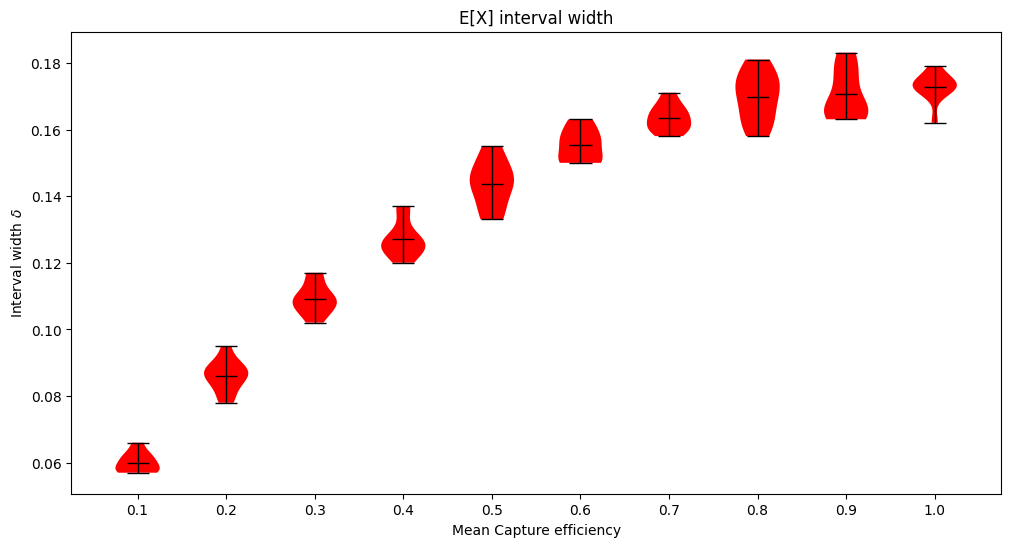

In [80]:
delta_plot = [[float(x) for x in delta_dict[m]['deltas']] for m in capture_means]

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    delta_plot,
    showextrema=True,
    showmeans=True
)
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor("red")
    vi.set_edgecolor(None)
    vi.set_alpha(1)

for partname in ['cbars','cmins','cmaxes','cmeans']:
    vi = vp[partname]
    vi.set_edgecolor("black")
    vi.set_linewidth(1)

labels = [f"{m}" for m in capture_means]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel("Mean Capture efficiency")
axs.set_ylabel(r"Interval width $\delta$")
axs.set_title(f'E[X] interval width')

Text(0.5, 1.0, 'E[X]**2 interval width')

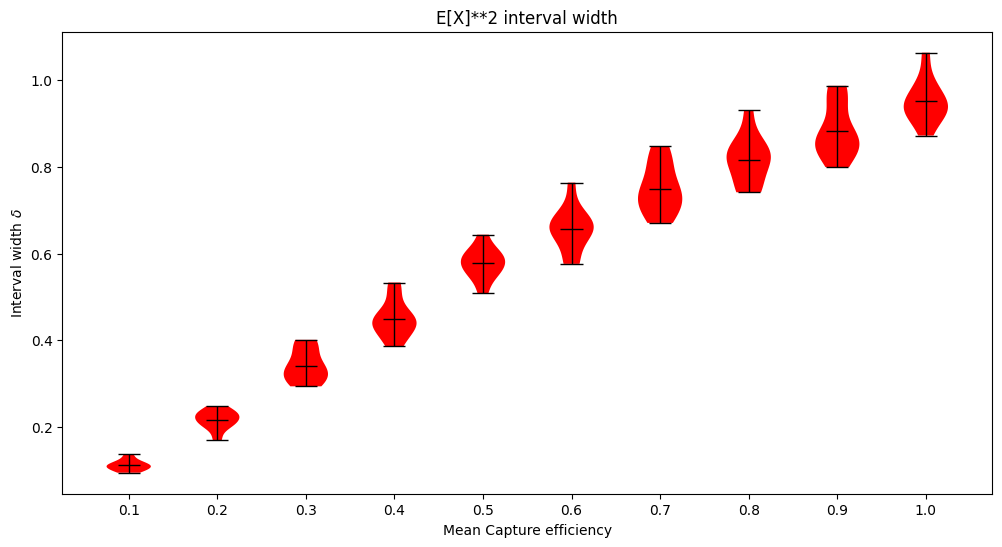

In [81]:
delta_plot = [[float(x) for x in delta_dict[m]['deltas_sq']] for m in capture_means]

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    delta_plot,
    showextrema=True,
    showmeans=True
)
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor("red")
    vi.set_edgecolor(None)
    vi.set_alpha(1)

for partname in ['cbars','cmins','cmaxes','cmeans']:
    vi = vp[partname]
    vi.set_edgecolor("black")
    vi.set_linewidth(1)

labels = [f"{m}" for m in capture_means]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel("Mean Capture efficiency")
axs.set_ylabel(r"Interval width $\delta$")
axs.set_title(f'E[X]**2 interval width')

In [85]:
dmeans = []
dsqmeans = []
for m in capture_means:
    deltas = delta_dict[m]['deltas']
    deltas_sq = delta_dict[m]['deltas_sq']
    
    dmeans.append(np.mean(deltas))
    dsqmeans.append(np.mean(deltas_sq))

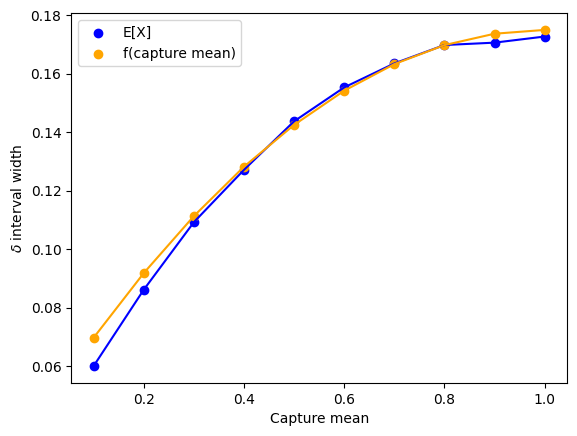

In [119]:
x = capture_means
def f(x):
    return 0.175 - 0.13*(x - 1)**2
y = [f(x) for x in x]
plt.scatter(x, dmeans, label="E[X]", color="blue")
plt.plot(x, dmeans, color="blue")
plt.scatter(x, y, label="f(capture mean)", color="orange")
plt.plot(x, y, color="orange")
plt.ylabel(r"$\delta$ interval width")
plt.xlabel(r"Capture mean")
plt.legend()

$$ f(m) = 0.175 - 0.13(m - 1)^2 $$

Function mapping mean capture $m$ to typical $\mathbb{E}[X]$ interval width $\delta$

Then see below that the typical width of $\mathbb{E}[X^2]$ interval $\delta_2$ is given by

$$ \delta_2 = 30\delta^2

Text(0, 0.5, 'Width')

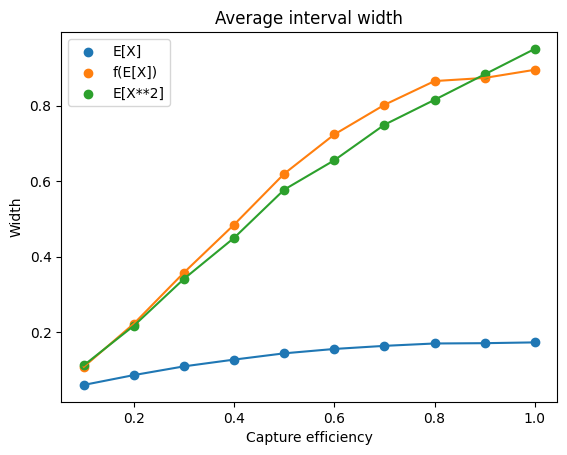

In [ ]:
adj = [30 * x**2 for x in dmeans]

plt.plot(capture_means, dmeans)
plt.scatter(capture_means, dmeans, label="E[X]")
plt.plot(capture_means, adj)
plt.scatter(capture_means, adj, label="f(E[X])")
plt.plot(capture_means, dsqmeans)
plt.scatter(capture_means, dsqmeans, label="E[X**2]")
plt.legend()
plt.title("Average interval width")
plt.xlabel("Capture efficiency")
plt.ylabel("Width")